In [1]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [2]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from kornia.enhance import normalize
from torchvision.transforms import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm.auto import tqdm

# typing
from typing import Callable

from utils import plot_images, plot_transform
from model import ConvNN, display_model

# os
import os
import path

import random
import numpy as np 

# transformations
# import transform as T
from randaugment import RandAugmentMC

# typing
from typing import Callable, List, Tuple

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%load_ext autoreload
%autoreload 2

In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [4]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.9 
LAMBDA_U = 3
MU = 4 # Coefficient for scaling the unlabeled loss
M = 4  # Number of strong augmentations per unlabeled example
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

In [6]:
class ConvNN(nn.Module):
    """
    Simple CNN for CIFAR10
    """
    
    def __init__(self):
        super().__init__()
        self.conv_32 = nn.Conv2d(3, 32, kernel_size=3, padding='same')
        self.conv_64 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv_96 = nn.Conv2d(64, 96, kernel_size=3, padding='same')
        self.conv_128 = nn.Conv2d(96, 128, kernel_size=3, padding='same')
        self.fc_512 = nn.Linear(512, 512)
        self.fc_10 = nn.Linear(512, 10)
        self.max_pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_32(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_64(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_96(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.conv_128(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.flatten(x)
        x = self.fc_512(x)
        x = self.relu(x)
        x = self.fc_10(x)

        return x

In [7]:
def compute_mean_std(trainLoader) -> Tuple[List[float], List[float]]:
    # initialize the list of means and stds
    mean, std = torch.zeros(3), torch.zeros(3)

    # iterate over the dataset and compute the sum of each channel
    for images, _ in trainLoader:
        mean+= torch.mean(images, dim=[0,2,3])
        std+= torch.std(images, dim=[0,2,3])
    
    # compute the mean and std
    mean = mean/len(trainLoader)
    std = std/len(trainLoader)

    return mean, std

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

if not os.path.exists('./data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, 'data/mean.pt')
    torch.save(std, 'data/std.pt')
else:
    mean, std = torch.load('./data/mean.pt'), torch.load('./data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
mean: [0.4913966  0.48215377 0.44651437], std: [0.246344   0.24280126 0.26067406]
Files already downloaded and verified


In [8]:
torch_models = 'torch_models' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## IV. Semi-Supervised Learning: Fixmatch - Data Alignment

### IV.1 Fixmatch on 10% train data - Data Alignment

In [9]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.10

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

In [11]:
def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

In [12]:
model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
# lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

In [13]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass in eval mode
        # with torch.no_grad():
        #     model.eval()
        labeled_outputs_norm = model(labeled_inputs)
        unlabeled_outputs_norm = model(unlabeled_inputs)

        # Compute moving average of labeled and unlabeled predictions
        moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = moving_avg_pred_labeled / moving_avg_pred_unlabeled
        # model.train()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 20.71%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 33.56%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 37.53%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 33.14%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 42.79%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 40.44%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.46%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.62%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.73%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.38%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.61%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.79%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.42%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.38%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.32%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.79%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.09%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.96%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.2%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.29%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.0%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.5%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.47%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.34%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.16%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.79%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.99%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.03%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.8%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.51%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.18%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.96%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.59%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.43%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.39%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.24%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.38%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.05%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.46%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.45%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.78%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.24%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.05%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.44%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.95%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.98%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.02%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.13%


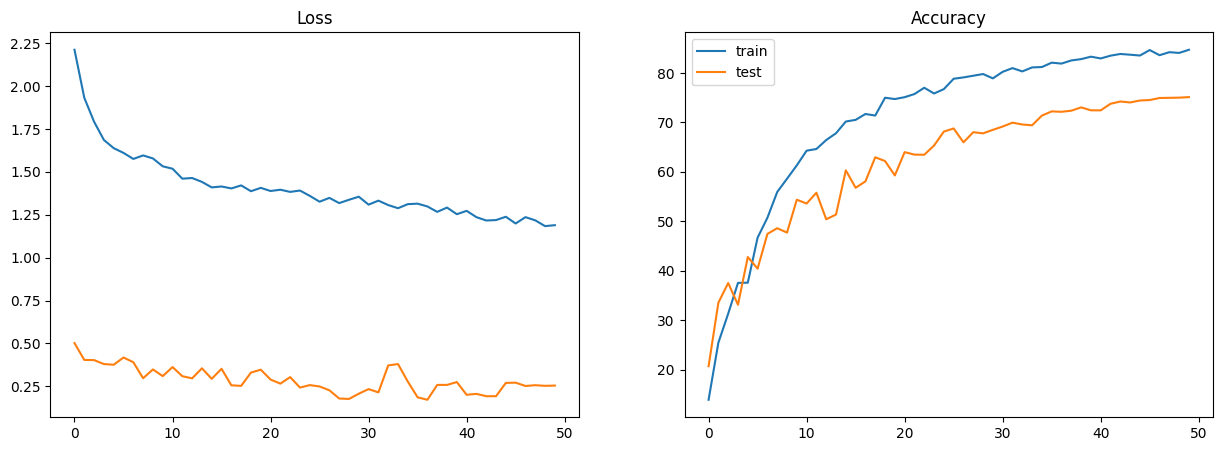

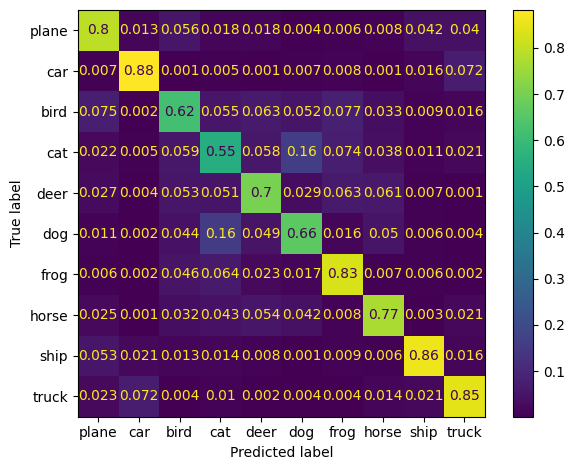

In [14]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()

Test Accuracy: 75.13%


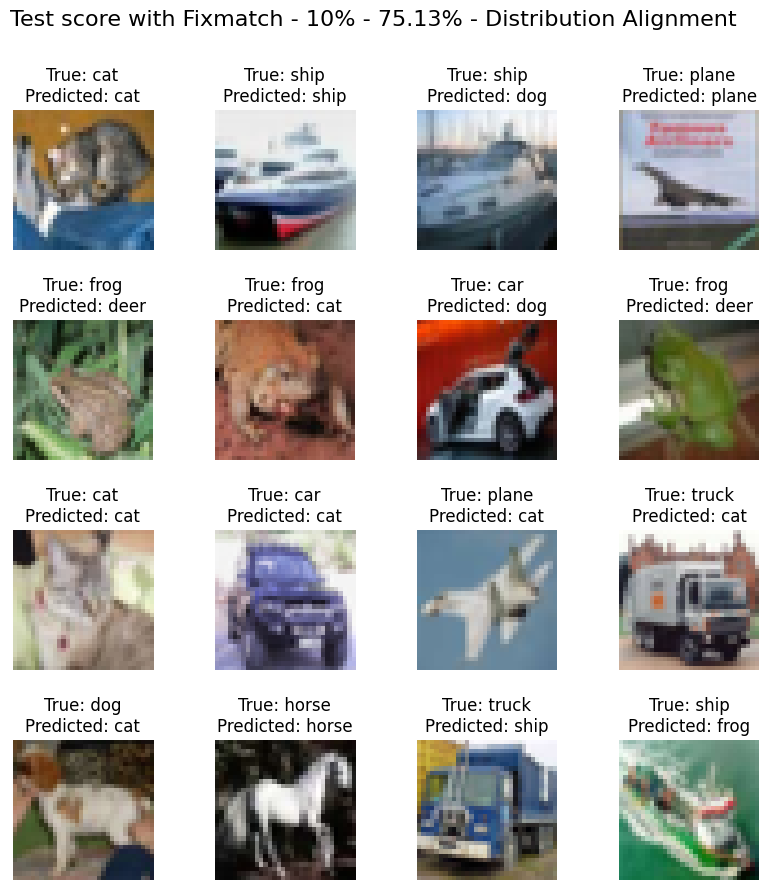

In [15]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_10_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Distribution Alignment")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch_DA.png")

### IV.2 Fixmatch on 5% train data - Data Alignment

In [16]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.05

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
# lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [17]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass in eval mode
        # with torch.no_grad():
        #     model.eval()
        labeled_outputs_norm = model(labeled_inputs)
        unlabeled_outputs_norm = model(unlabeled_inputs)

        # Compute moving average of labeled and unlabeled predictions
        moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = moving_avg_pred_labeled / moving_avg_pred_unlabeled
        # model.train()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.64%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 23.75%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 29.1%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 31.96%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 36.01%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 36.29%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.44%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 35.6%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.11%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.4%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 43.41%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 43.44%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.71%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.26%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 41.45%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.33%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.68%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.46%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.07%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.94%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.86%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.48%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.15%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.77%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.13%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.91%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.98%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.76%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.82%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.07%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.02%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.14%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.94%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.13%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.27%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.11%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.56%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.88%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.31%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.71%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.95%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.08%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.13%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.26%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.69%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.2%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.35%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.01%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.12%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.02%


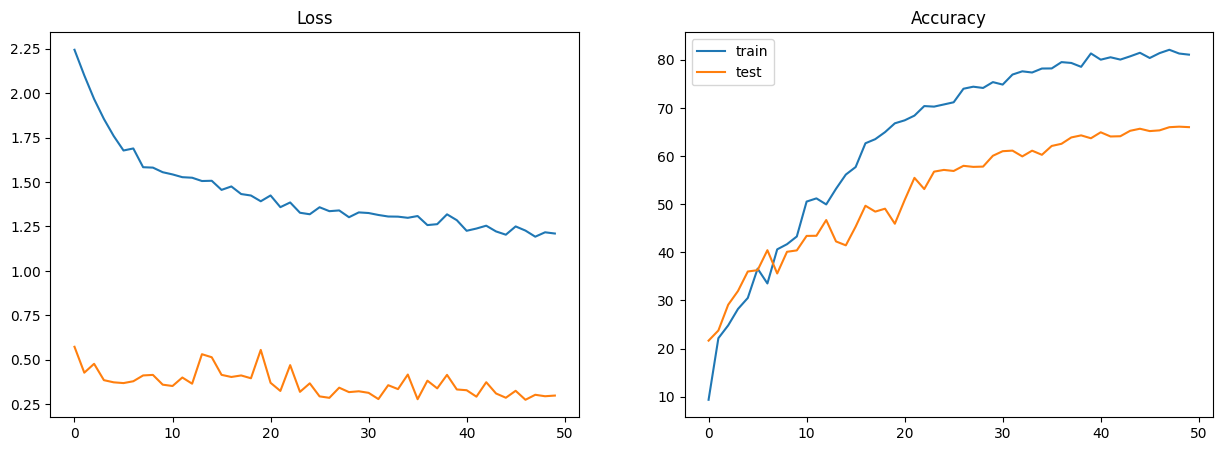

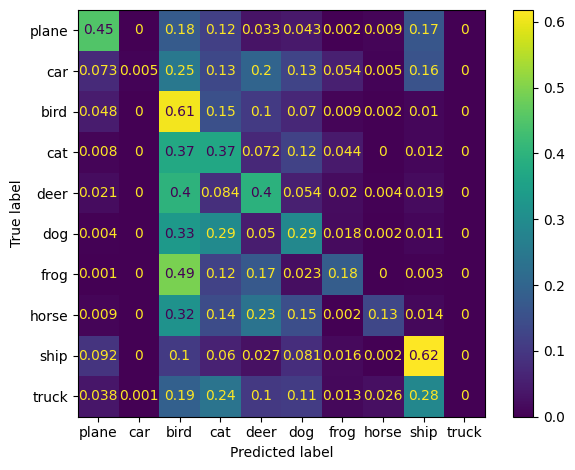

In [18]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()

Test Accuracy: 66.02%


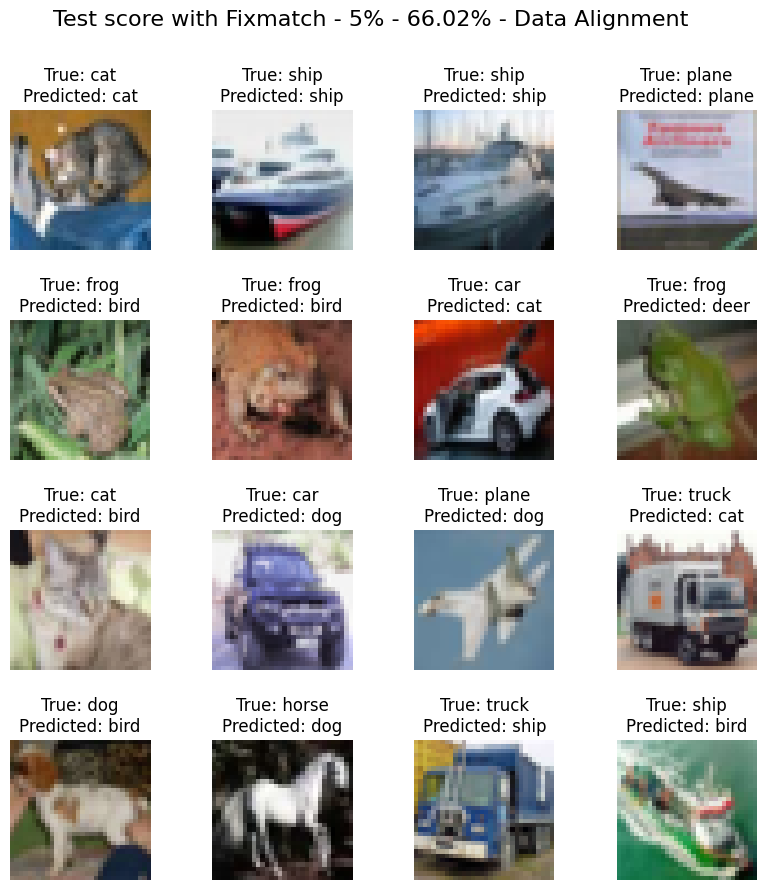

In [19]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_5_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Data Alignment")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch_DA.png")

### IV.3 Fixmatch on 1% train data - Data Alignment

In [20]:
# Define your dataset and dataloaders for labeled and unlabeled data
seedEverything()

EPOCHS = 50
SUBSET_PROP = 0.01

# 10% labeled data and 100% unlabeled (see note 2 in paper)
trainset_sup, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# transformations
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.125, 0.125)),
    # transforms.RandAugment(num_ops=2, magnitude=10),
    RandAugmentMC(n=2, m=10),
    # transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
    

def mask(model, weak_unlabeled_data):
    with torch.no_grad():
        model.train()

        qb = model(weak_unlabeled_data)

        # qb = logits.copy()
        qb = torch.softmax(qb, dim=1)

        max_qb, qb_hat = torch.max(qb, dim=1)

        idx = max_qb > TAU
        qb_hat = qb_hat[idx]

    return qb_hat.detach(), idx, max_qb.detach()

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# Define the cosine learning rate decay function
# lr_lambda = lambda step: LR * torch.cos(torch.tensor((7 * torch.pi * (step)) / (16 * EPOCHS))) * 100 / 3

# Create a learning rate scheduler with the cosine decay function
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# scheduler = None

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [21]:
print("Start training")

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    running_n_unlabeled = 0
    running_accuracy = 0
    moving_avg_pred_labeled = 0
    moving_avg_pred_unlabeled = 0


    pbar = tqdm(zip(labeled_dataloader, unlabeled_dataloader), total=min(len(labeled_dataloader), len(unlabeled_dataloader)), unit="batch", desc=f"Epoch {epoch: >5}")

    for i, (labeled_data, unlabeled_data) in enumerate(pbar):
        # Get labeled and unlabeled data
        labeled_inputs, labels = labeled_data[0].to(device), labeled_data[1].to(device)
        unlabeled_inputs, _ = unlabeled_data[0].to(device), unlabeled_data[1].to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass in eval mode
        # with torch.no_grad():
        #     model.eval()
        labeled_outputs_norm = model(labeled_inputs)
        unlabeled_outputs_norm = model(unlabeled_inputs)

        # Compute moving average of labeled and unlabeled predictions
        moving_avg_pred_labeled = (i * moving_avg_pred_labeled + labeled_outputs_norm.shape[0]) / (i + 1)
        moving_avg_pred_unlabeled = (i * moving_avg_pred_unlabeled + unlabeled_outputs_norm.shape[0]) / (i + 1)

        # ratio
        ratio = moving_avg_pred_labeled / moving_avg_pred_unlabeled
        # model.train()

        # Apply weak augmentation to labeled data
        weak_labeled_inputs = weak_transform(labeled_inputs)

        # Apply strong augmentation + weak augmentation to unlabeled data
        weak_unlabeled_inputs = weak_transform(unlabeled_inputs)
        strong_unlabeled_inputs = strong_transform(unlabeled_inputs)

        # prediction on weak augmented unlabeled data
        qb = model(weak_unlabeled_inputs)
        qb = torch.softmax(qb, dim=1)
        qb_norm = qb * ratio

        # normalize
        qb_tilde = qb_norm / torch.sum(qb_norm, dim=1, keepdim=True)

        # compute mask
        max_qb_tilde, qb_tilde_hat = torch.max(qb_tilde, dim=1)
        idx = max_qb_tilde > TAU

        # pseudo labels
        pseudo_labels = qb_tilde_hat[idx]

        # mask strong augmented unlabeled data
        strong_unlabeled_inputs = strong_unlabeled_inputs[idx]

        n_labeled, n_unlabeled = weak_labeled_inputs.size(0), strong_unlabeled_inputs.size(0)

        if n_unlabeled != 0:
            # Concatenate labeled and unlabeled data
            inputs_all = torch.cat((weak_labeled_inputs, strong_unlabeled_inputs))
            labels_all = torch.cat((labels, pseudo_labels))

            # forward pass
            outputs = model(inputs_all)
            # outputs = torch.softmax(outputs, dim=1)

            # split labeled and unlabeled outputs
            labeled_outputs, unlabeled_outputs = outputs[:n_labeled], outputs[n_labeled:]

            # compute losses
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.sum(unlabeled_criterion(unlabeled_outputs, pseudo_labels)) / (MU * BATCH_SIZE)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels_all.size(0)
            correct += (outputs.argmax(dim=1) == labels_all).sum().item()
            
        else:
            # forward pass
            labeled_outputs = model(weak_labeled_inputs)
            # labeled_outputs = torch.softmax(labeled_outputs, dim=1)

            # compute loss
            labeled_loss = torch.sum(labeled_criterion(labeled_outputs, labels)) / BATCH_SIZE
            unlabeled_loss = torch.tensor(0, device=device)

            # compute total loss
            loss = labeled_loss + LAMBDA_U * unlabeled_loss

            # compute accuracy
            total += labels.size(0)
            correct += (labeled_outputs.argmax(dim=1) == labels).sum().item()


        # backward pass + optimize
        loss.backward()
        optimizer.step()

        

        # update statistics
        running_loss += loss.item()
        running_n_unlabeled += n_unlabeled
        running_accuracy += 100 * correct / total

        

        # update progress bar
        pbar.set_postfix({
            "labeled loss": labeled_loss.item(),
            "unlabeled loss": unlabeled_loss.item(),
            "accuracy": 100 * correct / total,
            "avg confidence": torch.mean(max_qb_tilde).item(),
            "n_unlabeled": running_n_unlabeled,
            "lr": optimizer.param_groups[0]['lr']
        })

    # update loss
    train_losses.append(running_loss / (i + 1))
    train_accuracies.append(running_accuracy / (i + 1))

    # scheduler step
    if scheduler is not None:
        scheduler.step()

    
    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # normalize
            images = normalize(data=images, mean=mean, std=std)
            
            outputs = model(images)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
        
        test_accuracy = 100.0 * test_correct / test_total
        print(f'Test Accuracy: {test_accuracy}%')

        # update loss
        test_losses.append(torch.sum(labeled_criterion(outputs, labels)).item() / BATCH_SIZE)
        test_accuracies.append(test_accuracy)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 13.42%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 19.21%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 19.54%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.07%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 21.86%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 23.41%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.0%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.02%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.78%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.14%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.64%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.6%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 31.11%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.24%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.36%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.36%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.08%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.58%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.33%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.25%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 34.73%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.5%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.34%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.69%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.77%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.33%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.92%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.36%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.44%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.05%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.19%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.73%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.56%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.85%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.94%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.08%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.91%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.6%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.44%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.29%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.43%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.52%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.28%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.5%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.62%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.66%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.67%


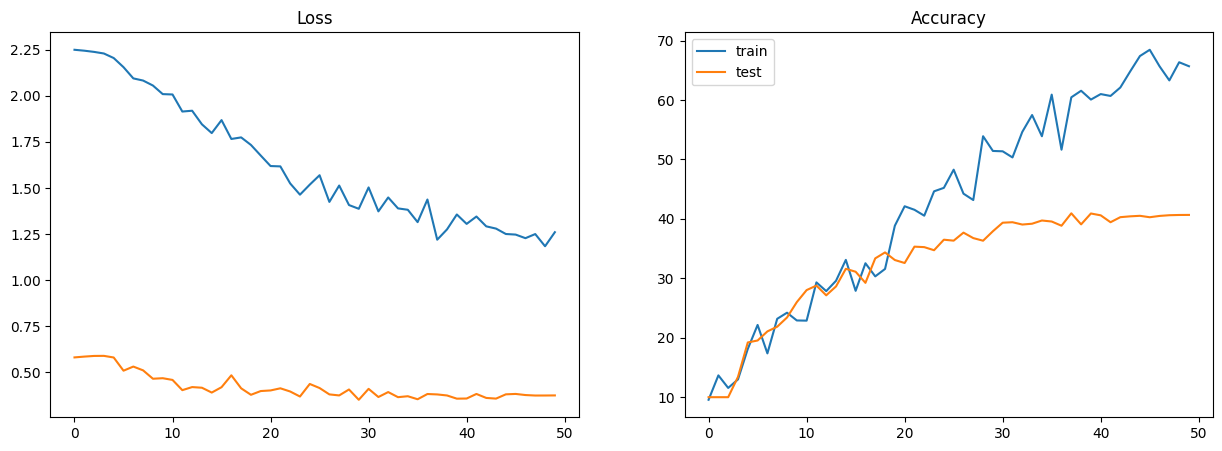

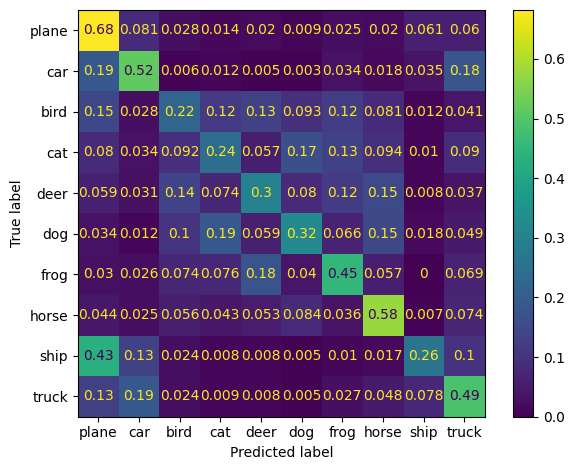

In [22]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies, label="train")
ax2.plot(test_accuracies, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.tight_layout()
    plt.show()

Test Accuracy: 40.67%


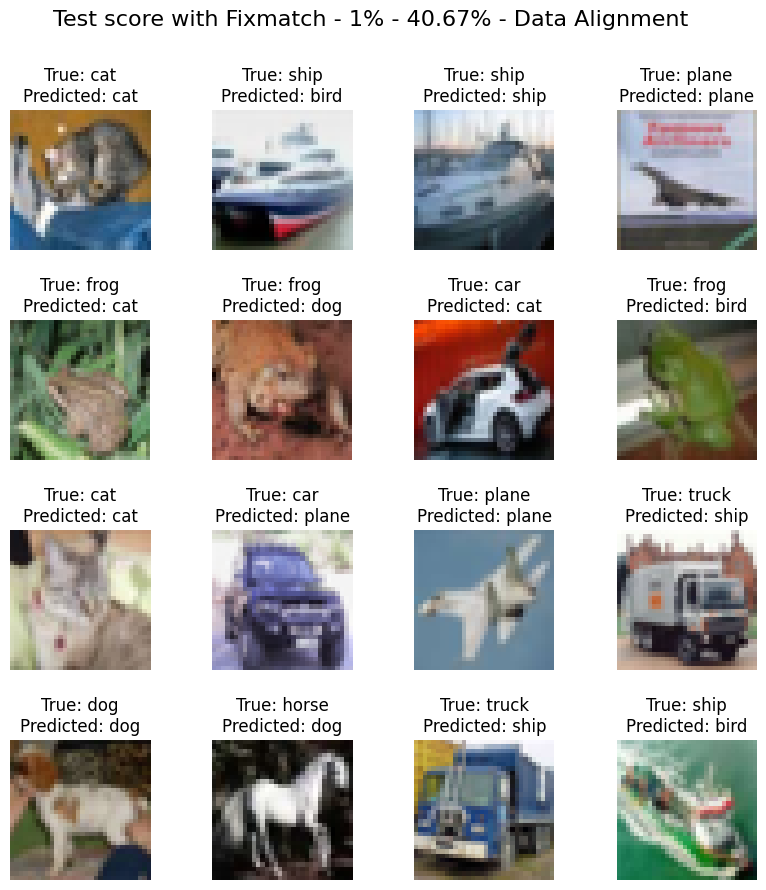

In [23]:
# Evaluation on the test set
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(data=images, mean=mean, std=std)
        
        outputs = model(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

# save the model
torch.save(model.state_dict(), f"{torch_models}/model_1_fixmatch_DA.pth")

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

# descale the images
test_image = test_image#  * torch.tensor(std, device=device).view(1, 3, 1, 1) + torch.tensor(mean, device=device).view(1, 3, 1, 1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}% - Data Alignment")
fig1.savefig(f"./figures/test_score_{SUBSET_PROP}_fixmatch_DA.png")